<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [9]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [10]:
from sklearn import model_selection 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [ ]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

### Others options

In [11]:
path = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv'

### Load Data From CSV File  

In [12]:
df = pd.read_csv(path)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [13]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [14]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [15]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Mokht\Anaconda3

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.3.9           |           py37_0         155 KB  anaconda
    conda-4.7.10               |           py37_0         3.0 MB  anaconda
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi                                       conda-forge --> anaconda
  conda                                         conda-forge --> anaconda




certifi-2019.3.9     | 155 KB    |            |   0% 
certifi-2019.3.9     | 155 KB    | #          |  10% 
certifi-2019.3.9     | 155 KB    | #######2   |  72% 
certifi-2019.3.9     | 155 KB    | ###

In [16]:
import seaborn as sns

## Histogram of 'Principal'

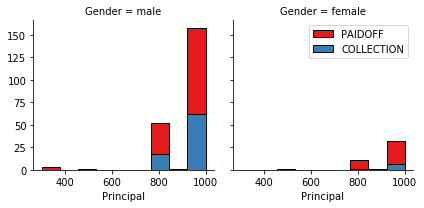

In [17]:


bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Histogram for 'age'

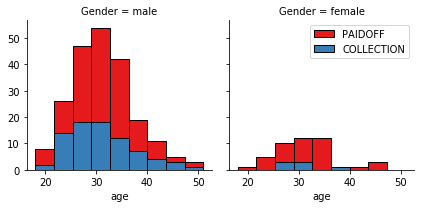

In [18]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

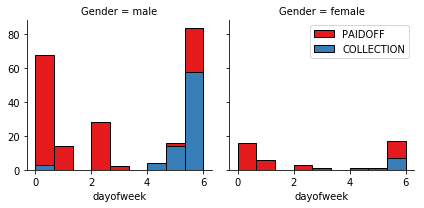

In [19]:
df['dayofweek'] = df['effective_date'].dt.dayofweek

bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)

g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [20]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [21]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [22]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [23]:
values_counts = df.groupby(['education'])['loan_status'].value_counts(normalize=True)

In [24]:
values_counts

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [25]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [26]:
Feature = df[['Principal','terms','age','Gender','weekend']]

Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)

Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [27]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [28]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [29]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

C:\Users\Mokht\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Mokht\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [ ]:
X= preprocessing.StandardScaler().fit(X).transform(X.astype(int))
X[0:5]

 # Reprocessing Time

In [30]:
from sklearn import model_selection

In [31]:
from sklearn.model_selection import train_test_split

In [43]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

print('Train set:', X_train.shape, y_train.shape)

print('Test set:', X_test.shape, y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [51]:
from sklearn.neighbors import KNeighborsClassifier

In [46]:
from sklearn import neighbors

In [44]:
neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)

In [52]:
grid={'n-neighbors':[1,2,3,4,5,6,7,8,9,10]}


neigh = neighbors.KNeighborsClassifier(grid)

gridSearchObj=model_selection.GridSearchCV(neigh,grid,cv=3)
gridSearchObj.fit(X_train,y_train)
gridSearchObj.best_parameters()

ValueError: Invalid parameter n-neighbors for estimator KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None,
           n_neighbors={'n-neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
           p=2, weights='uniform'). Check the list of available parameters with `estimator.get_params().keys()`.

In [63]:
from sklearn import model_selection
from sklearn import neighbors
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.33)
grid={'n-neighbors':[1,2,3,4,5,6,7,8,9,10]}

knn_model=neighbors.KNeighborsClassifier(n_neighbors=7)
grid={'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
gridSearchObj=model_selection.GridSearchCV(knn_model,grid,cv=3)
gridSearchObj.fit(X_train,y_train)

knn_model.fit(X_train,y_train)
pred_y=knn_model.predict(X_test)

print(pred_y)

jaccardscore=jaccard_similarity_score(y_test,pred_y)
f1_score(y_test,pred_y)
print(jaccardscore)
print(f1score)

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'COLLECTION' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAI

C:\Users\Mokht\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Mokht\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1037: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:


ValueError: pos_label=1 is not a valid label: array(['COLLECTION', 'PAIDOFF'], dtype='<U10')

In [42]:
k=4

#Train model & Predict

neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [28]:
KNN_yhat = neigh.predict(X_test)
KNN_yhat[0:5]

array(['COLLECTION', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

## *Evaluation*

In [29]:
from sklearn import metrics

In [30]:
print('Train set accuraycy:', metrics.accuracy_score(y_train, neigh.predict(X_train)))

print('Test set accuracy:', jaccard_similarity_score(y_test, KNN_yhat))

Train set accuraycy: 0.8188405797101449
Test set accuracy: 0.6714285714285714


In [31]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, KNN_yhat)

0.6714285714285714

# Loops for testing different K

In [8]:
# Others solutions ?'

grid={'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
gridSearchObj=model_selection.GridSearchCV(knn_model,grid,cv=3)
gridSearchObj.fit(X_train,y_train)
gridSearchObj.best_params_'''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-8-d7e6a0224ce0>, line 6)

In [32]:
Ks = 10

mean_acc = np.zeros((Ks-1))

std_acc = np.zeros((Ks-1))

ConfustionMX = [];

for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors= Ks).fit(X_train, y_train)
    yhat= neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, KNN_yhat)


    std_acc[n-1] = np.std( yhat==y_test)/ np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.67142857, 0.67142857, 0.67142857, 0.67142857,
       0.67142857, 0.67142857, 0.67142857, 0.67142857])

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,preds,labels=[1,0]))
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_test,preds),annot=True,lw =2,cbar=False)
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("CONFUSSION MATRIX VISUALIZATION")
plt.show()

# Plot accuracy with different model of KNN

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,preds,labels=[1,0]))
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_test,preds),annot=True,lw =2,cbar=False)
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("CONFUSSION MATRIX VISUALIZATION")
plt.show()

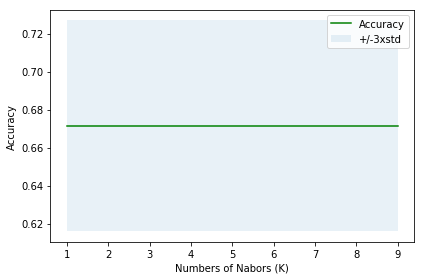

In [34]:
plt.plot(range(1,Ks), mean_acc,'g')

plt.fill_between(range(1,Ks), mean_acc -1* std_acc,  mean_acc +1* std_acc, alpha=0.10)

plt.legend(("Accuracy", '+/-3xstd'))

plt.ylabel('Accuracy')

plt.xlabel('Numbers of Nabors (K)')

plt.tight_layout()

plt.show()

In [5]:
print("The best accuracy was with:", mean_acc.max(), "with=k:", mean_acc.argmax()+1)

NameError: name 'mean_acc' is not defined

In [36]:
from sklearn.metrics import classification_report 
import itertools
print(classification_report(y_test,KNN_yhat))

              precision    recall  f1-score   support

  COLLECTION       0.24      0.42      0.30        12
     PAIDOFF       0.86      0.72      0.79        58

   micro avg       0.67      0.67      0.67        70
   macro avg       0.55      0.57      0.54        70
weighted avg       0.75      0.67      0.70        70



In [4]:
from sklearn import metrics
print("tEST KNN='s Accuracy:", metrics.accuracy_score(y_test, neigh.predict(X_train))

SyntaxError: unexpected EOF while parsing (<ipython-input-4-6204cdcfcd01>, line 2)

In [ ]:
print(" Test Linear_SVM Accuracy: %.7f" % jaccard_similarity_score(y_test, Lim_SVM_yhat))

In [38]:
from sklearn.metrics import f1_score
f1_score(y_test, KNN_yhat, average='weighted')

0.7024153416676782

In [39]:
from sklearn.metrics import confusion_matrix
import itertools
print(confusion_matrix(y_test, KNN_yhat))

[[ 5  7]
 [16 42]]


In [53]:
from sklearn.metrics import confusion_matrix
import itertools
print(confusion_matrix(y_test, yhat))

[[ 9  6]
 [17 38]]


# OTHERS EXAM

In [81]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
svmModel=svm.SVC(kernel='sigmoid')
grid={'kernel':['linear','poly','rbf','sigmoid']}
gridsearchobj=GridSearchCV(svmModel,grid,cv=3)
gridsearchobj.fit(X_train,y_train)
gridsearchobj.best_params_
svmModel.fit(X_train,y_train)
svmPred_y=svmModel.predict(X_test)
SVMjaccardSimilarityScore=jaccard_similarity_score(y_test,svmPred_y)
print(SVMjaccardSimilarityScore)
f1_score(y_test,svmPred_y,average='micro')
svmmodel_final=svmModel.fit(X,y)

0.7304347826086957


C:\Users\Mokht\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Mokht\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Mokht\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Mokht\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

ValueError: Found input variables with inconsistent numbers of samples: [54, 346]

# Decision Tree

## OTHERS

In [82]:
decisionTreeModel=DecisionTreeClassifier(criterion='gini',max_depth=1,random_state=5)
#criterion='gini',max_depth=20,random_state=5
#grid={'criterion':['entropy','gini'],'max_depth':[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,45,46,47],'random_state':[25]}
#gridSearchObj=GridSearchCV(decisionTreeModel,grid,cv=3)

In [84]:
from sklearn import model_selection
from sklearn import neighbors
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.33)
#grid={'n-neighbors':[1,2,3,4,5,6,7,8,9,10]}
#gridSearchObj=model_selection.GridSearchCV()
knn_model=neighbors.KNeighborsClassifier(n_neighbors=7)
'''grid={'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
gridSearchObj=model_selection.GridSearchCV(knn_model,grid,cv=3)
gridSearchObj.fit(X_train,y_train)
gridSearchObj.best_params_'''
knn_model.fit(X_train,y_train)
pred_y=knn_model.predict(X_test)
#print(pred_y)
#y_test.replace(to_replace=['male','female'], value=[0,1],inplace=True)
jaccardscore=jaccard_similarity_score(y_test,pred_y)
f1_score(y_test,pred_y)
#print(jaccardscore)
#print(f1score)

ValueError: Found input variables with inconsistent numbers of samples: [54, 346]

In [68]:
jaccardscore=jaccard_similarity_score(y_test,pred_y)
print(jaccardscore)

f1_score(y_test,pred_y,average ='micro')

#Till Now I have searched the best parameter i.e K=7 using grid search and then calculated jaccard score and f1 score for them. Now what I will do is, I will train model with entire data. so that I can test it with test data imported below.
knn_model_final=knn_model.fit(X,y)

0.7130434782608696


In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
decisionTreeModel=DecisionTreeClassifier(criterion='gini',max_depth=1,random_state=5)
#criterion='gini',max_depth=20,random_state=5
#grid={'criterion':['entropy','gini'],'max_depth':[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,45,46,47],'random_state':[25]}
#gridSearchObj=GridSearchCV(decisionTreeModel,grid,cv=3)
#gridSearchObj.fit(X_train,y_train)
#gridSearchObj.best_params_
decisionTreeModel.fit(X_train,y_train)
Decisionpred_y=decisionTreeModel.predict(X_test)
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
decjaccardSimilarityScore=jaccard_similarity_score(y_test,Decisionpred_y)
print(decjaccardSimilarityScore)
f1_score(y_test,Decisionpred_y,average='micro')
#Now training the model with entire dataset


decisiontreemodel_Final=decisionTreeModel.fit(X,y)

0.7391304347826086


ValueError: Number of labels=346 does not match number of samples=54

# ME 

In [65]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
loanTree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
loanTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
loanTree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [43]:
predTree = loanTree.predict(X_test)

print(predTree[0:5])
print(y_test[0:5])

['COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']
['COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']


## Evaluation of Tree

In [44]:
from sklearn.metrics import classification_report 
import itertools
print(classification_report(y_test,predTree))

              precision    recall  f1-score   support

  COLLECTION       0.32      0.58      0.41        12
     PAIDOFF       0.90      0.74      0.81        58

   micro avg       0.71      0.71      0.71        70
   macro avg       0.61      0.66      0.61        70
weighted avg       0.80      0.71      0.74        70



In [ ]:
print('Train set accuracy:', metrics.accuracy_score(y_train, loanTree.predict(X_train)))


In [ ]:
from sklearn import metrics
print("Test Decision Trees's Accuracy:", jaccard_similarity_score(y_test, predTree))

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, predTree, average='weighted')

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
print(confusion_matrix(y_test, predTree))

### Visualisation of Tree

In [47]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: ...working... 
  - anaconda::ca-certificates-2019.1.23-0, anaconda::openssl-1.1.1b-he774522_1
  - anaconda::ca-certificates-2019.1.23-0, defaults::openssl-1.1.1b-he774522_1
  - anaconda::openssl-1.1.1b-he774522_1, defaults::ca-certificates-2019.1.23-0
  - defaults::ca-certificates-2019.1.23-0, defaults::openssl-1.1.1b-he774522_1done

## Package Plan ##

  environment location: C:\Users\Mokht\Anaconda3

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.3.9           |           py37_0         149 KB  conda-forge
    conda-4.7.10               |           py37_0         3.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi                 

In [ ]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline



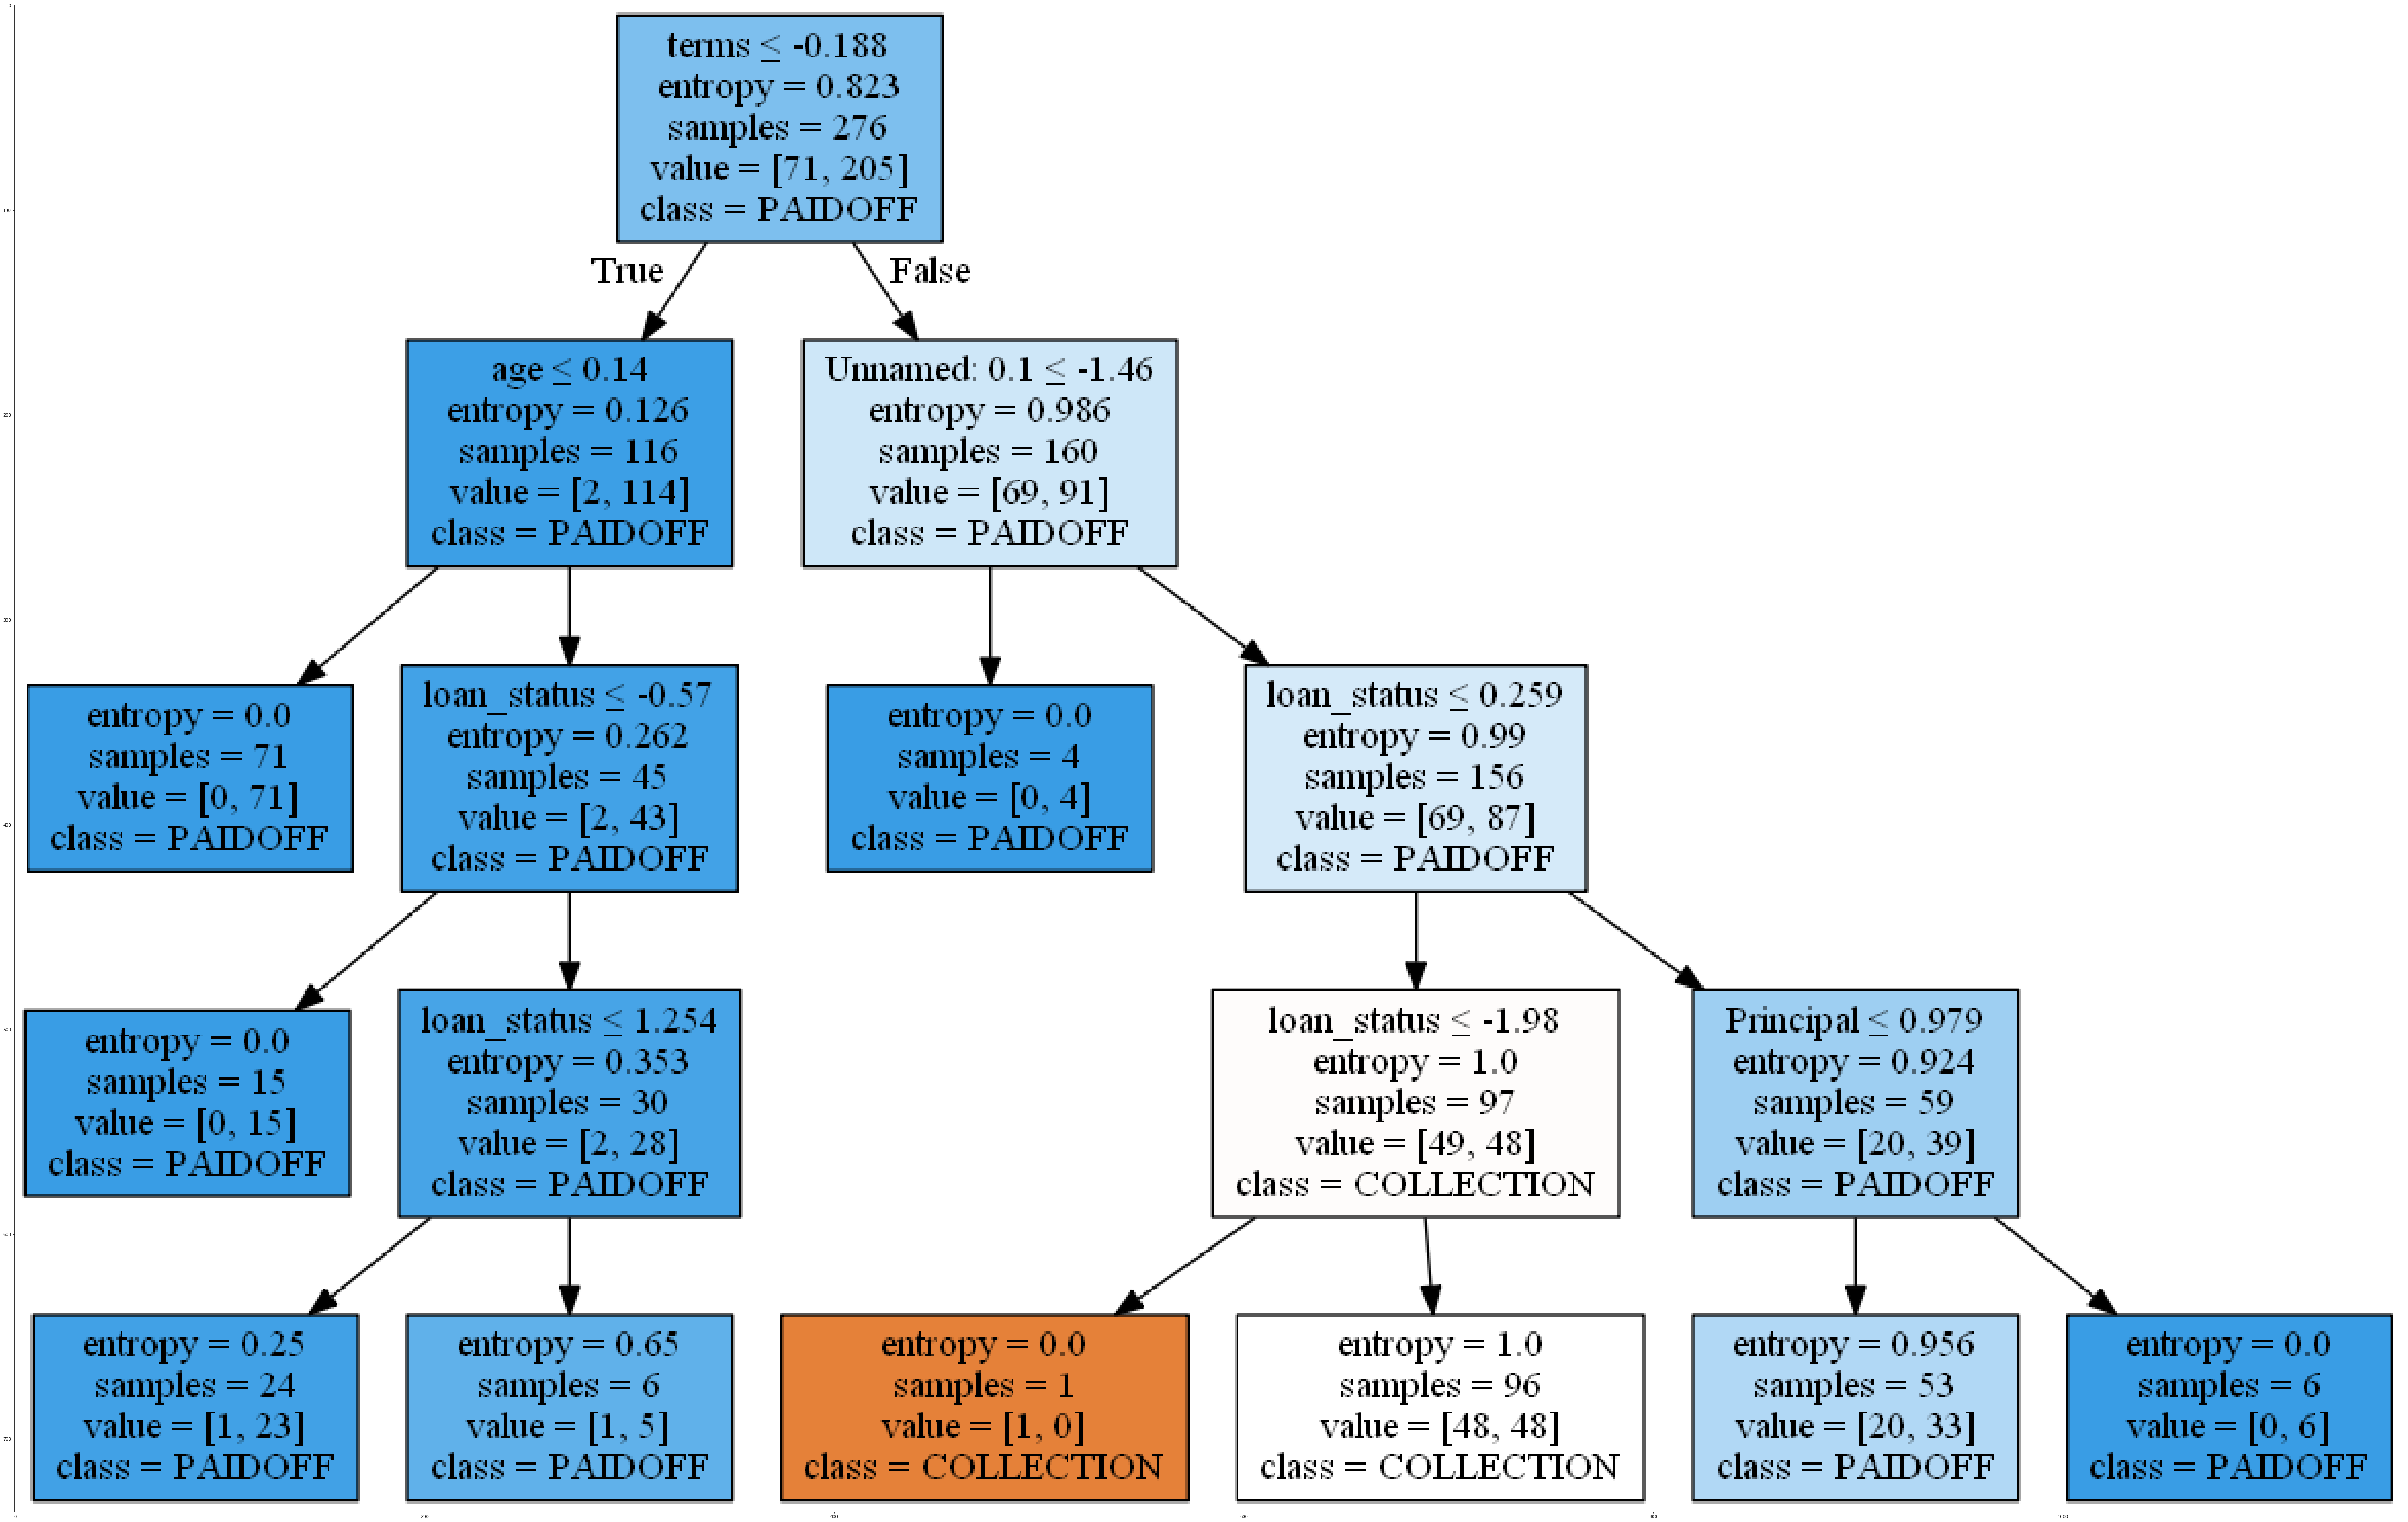

In [73]:
dot_data = StringIO()
file_name ='loantree.png'
featureNames = df.columns[0:8]

targetNames = df['loan_status'].unique().tolist()

out= tree.export_graphviz( loanTree, feature_names= featureNames, out_file= dot_data, class_names=np.unique(y_train), 
                          filled=True, special_characters = True, rotate=False)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_png(file_name)

img =mpimg.imread(file_name)


plt.figure(figsize=(100,200))
plt.imshow(img, interpolation='nearest')



In [ ]:
dot_data = StringIO()
file_name ='loantree.png'
featureNames = loan_data.columns[0:5]

targetNames = loan_data['Drugs'].unique().tolist()

out= tree.export_graphviz( loanTree, feature_names= featureNames, out_file= dot_data, class_names=np.unique(y_train), filled=True,
                          special_characters = True, rotate=False)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_png(filename)

img =mpimg.imread(filename)

plt.figure(figsize-(100,200))

plt.imshow(img, interpolation='nearest')

# Support Vector Machine

# ME 

In [88]:
from sklearn import svm
SVM = svm.SVC(kernel='rbf')
SVM.fit(X_train, y_train)


C:\Users\Mokht\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [87]:
SVM_yhat = SVM.predict(X_test)

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import classification_report 
import itertools
print(classification_report(y_test,yhat))

In [92]:
from sklearn.metrics import confusion_matrix
import itertools
print(confusion_matrix(y_test, SVM_yhat))

[[ 4 11]
 [ 7 48]]


In [ ]:
print('Train SVM set accuracy:', metrics.accuracy_score(y_train, SVM.predict(X_test)))

In [89]:
from sklearn import metrics
print("SVM='s Accuracy:", jaccard_similarity_score(y_test, SVM_yhat))

SVM='s Accuracy: 0.7428571428571429


In [90]:
from sklearn.metrics import f1_score
f1_score(y_test, SVM_yhat, average='weighted')

0.7275882012724117

In [91]:
from sklearn.metrics import confusion_matrix
import itertools
print(confusion_matrix(y_test, SVM_yhat))

[[ 4 11]
 [ 7 48]]


In [93]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, SVM_yhat)


0.7428571428571429

# SVM Linear

In [95]:
Lim_SVM = svm.SVC(kernel='linear') #'linear','poly','rbf','sigmoid']
Lim_SVM.fit(X_train, y_train)



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [96]:
Lim_SVM_yhat = Lim_SVM.predict(X_test)

In [ ]:
print("Train Linear_SVM Accuracy: %.4f" % metrics.accuracy_score(y_test, Lim_SVM.predict(X_test)))

In [ ]:
print(" Test Linear_SVM = Jaccard score: %.4f" % jaccard_similarity_score(y_test, Lim_SVM_yhat))

In [48]:
print("Linear SVM = Avg F1-score: %.4f" % f1_score(y_test, Lim_SVM_yhat, average='weighted'))


NameError: name 'Lim_SVM_yhat' is not defined

In [99]:
print(" Linear_SVM = Jaccard score: %.4f" % jaccard_similarity_score(y_test, Lim_SVM_yhat))

Jaccard score: 0.7857


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
print(confusion_matrix(y_test, Lim_SVM_yhat))

### Plot confusion_matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
    cm= cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("Normalized confusion matrix")
else:
print('Confusion matrix, without normalization')
print(cm)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
""" This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.""";

if normalize:
cm = cm.astype('oat') / cm.sum(axis=1)[:, np.newaxis]
print("Normalized confusion matrix")
else:
print('Confusion matrix, without normalization')
print(cm)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
plt.text(j, i, format(cm[i, j], fmt),
horizontalalignment="center",
color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
def plot_confusion_matrix(cm, classes,
normalize=False,
title='Confusion matrix',
cmap=plt.cm.Blues):
"""
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.
"""
if normalize:
cm = cm.astype('oat') / cm.sum(axis=1)[:, np.newaxis]
print("Normalized confusion matrix")
else:
print('Confusion matrix, without normalization'

# Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
LRmodel=LogisticRegression(C=0.019,solver='newton-cg')
#grid={'C':[0.01,0.018,0.02,0.04,0.05,0.06,0.07,0.08],'solver':['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']}
#GridSearchCVobj=GridSearchCV(LRmodel,grid,cv=3)
#GridSearchCVobj.fit(X_train,y_train)
#GridSearchCVobj.best_params_
LRmodel.fit(X_train,y_train)
LRpred_y=LRmodel.predict(X_test)
LRpresprob_y=LRmodel.predict_proba(X_test)
LRjaccard_similarityScore=jaccard_similarity_score(y_test,LRpred_y)
print(LRjaccard_similarityScore)
f1_score(y_test,LRpred_y,average='micro')
log_loss(y_test,LRpresprob_y)
LRmodelfinal=LRmodel.fit(X,y)

0.7391304347826086


# ME 

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train) 
# others solver ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']}
LR

NameError: name 'X_train' is not defined

In [ ]:
LRyhat = LR.predict(X_test)
LRyhat


In [ ]:
LRyhat_prob = LR.predict_proba(X_test)
LRyhat_prob


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
print(confusion_matrix(y_test, LRyhat))

In [ ]:
print(classification_report(y_test, LRyhat))

In [ ]:
print("Train Linear_SVM Accuracy: %.4f" % metrics.accuracy_score(y_test, LR.predict(X_test)))

In [ ]:
print(" Test Linear_SVM = Jaccard score: %.4f" % jaccard_similarity_score(y_test, LR_yhat))

In [ ]:
print("Log Regression F1-score: %.7f" % f1_score(y_test, LR_yhat, average='weighted'))

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test, LRyhat_prob)

In [ ]:
print(classification_report(y_test, LRyhat))

In [ ]:
print(classification_report(y_test, LRyhat_prob))

# Model Evaluation using Test set

In [ ]:
from sklearn import metrics

from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation 

In [74]:
url_test = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'

test_df = pd.read_csv(url_test)
test_df.shape
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [76]:
test_df['Gender'].replace(to_replace=['male','female'],value=[0,1],inplace=True)
test_df.head(5)
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
FeatureTest=test_df[['Principal','terms','age','Gender','weekend']]
print(FeatureTest.shape)
FeatureTest=pd.concat([FeatureTest,pd.get_dummies(test_df['education'])],axis=1)
#Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
FeatureTest.drop(['Master or Above'],axis=1,inplace=True)
print(type(FeatureTest))
print(FeatureTest.shape)

(54, 5)
<class 'pandas.core.frame.DataFrame'>
(54, 8)


In [79]:
Feature.head(5)
X=FeatureTest
#X.fillna(value=X.mean(),inplace=True,axis=1)
X=preprocessing.StandardScaler().fit(X).transform(X)
print(X.shape)

#X= preprocessing.StandardScaler().fit(X).transform(X)
ytest=test_df['loan_status']
print(ytest.shape)
KNNyhat=knn_model_final.predict(X)
decisionyhat=decisiontreemodel_Final.predict(X)
svmyhat=svmmodel_final.predict(X)
LRyhat=LRmodelfinal.predict(X)
LRyhatprob=LRmodelfinal.predict_proba(X)
print('jaccard_similarity_score for KNN ',jaccard_similarity_score(y,KNNyhat))
print('jaccard_similarity_score for Decision  Tree',jaccard_similarity_score(y,decisionyhat))
print('jaccard_similarity_score for Logistic ',jaccard_similarity_score(y,LRyhat))
print('jaccard_similarity_score for SVM ',jaccard_similarity_score(y,svmyhat))

print('F1- score for KNN',f1_score(y,KNNyhat,average='micro'))
print('F1- score for Decision  Tree',f1_score(y,decisionyhat,average='micro'))
print('F1- score for Logistic',f1_score(y,LRyhat,average='micro'))
print('F1- score for SVM',f1_score(y,svmyhat,average='micro'))

print('log- loss for logistic regression ',log_loss(ytest,LRyhatprob))

(54, 8)
(54,)


C:\Users\Mokht\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Mokht\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


NameError: name 'decisiontreemodel_Final' is not defined

In [ ]:
report_data = {'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'], 
               'F1-score': [knnf1,dtf1,svmf1,lrf1],
               'Jaccard': [knnjac,dtjac,svmjac,lrjac],
               'LogLoss': ['NA','NA','NA',lrlogloss]
               }
report_df = pd.DataFrame.from_dict(report_data)
report_df

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>